In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
red = pd.read_csv("winequality-red.csv", delimiter=";")
white = pd.read_csv("winequality-white.csv", delimiter=";")

white.size

58776

**Red vs White EDA**

In [4]:
red["color"] = "Red"
white["color"] = "White"

In [5]:
wines = pd.concat([red, white])

Text(0, 0.5, 'Number of Examples')

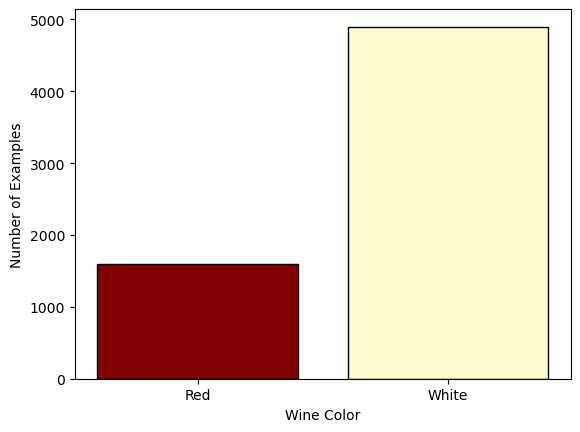

In [6]:
counts = wines.groupby("color").count()
colors = ["maroon", "lemonchiffon"]
edgecolors = ["black", "black"]
plt.bar(counts.index, counts.quality, color = colors, edgecolor=edgecolors)
plt.xlabel("Wine Color")
plt.ylabel("Number of Examples")

In [7]:
features = list(wines.columns)[:-2]
features_and_label = list(wines.columns)[:-1]

features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

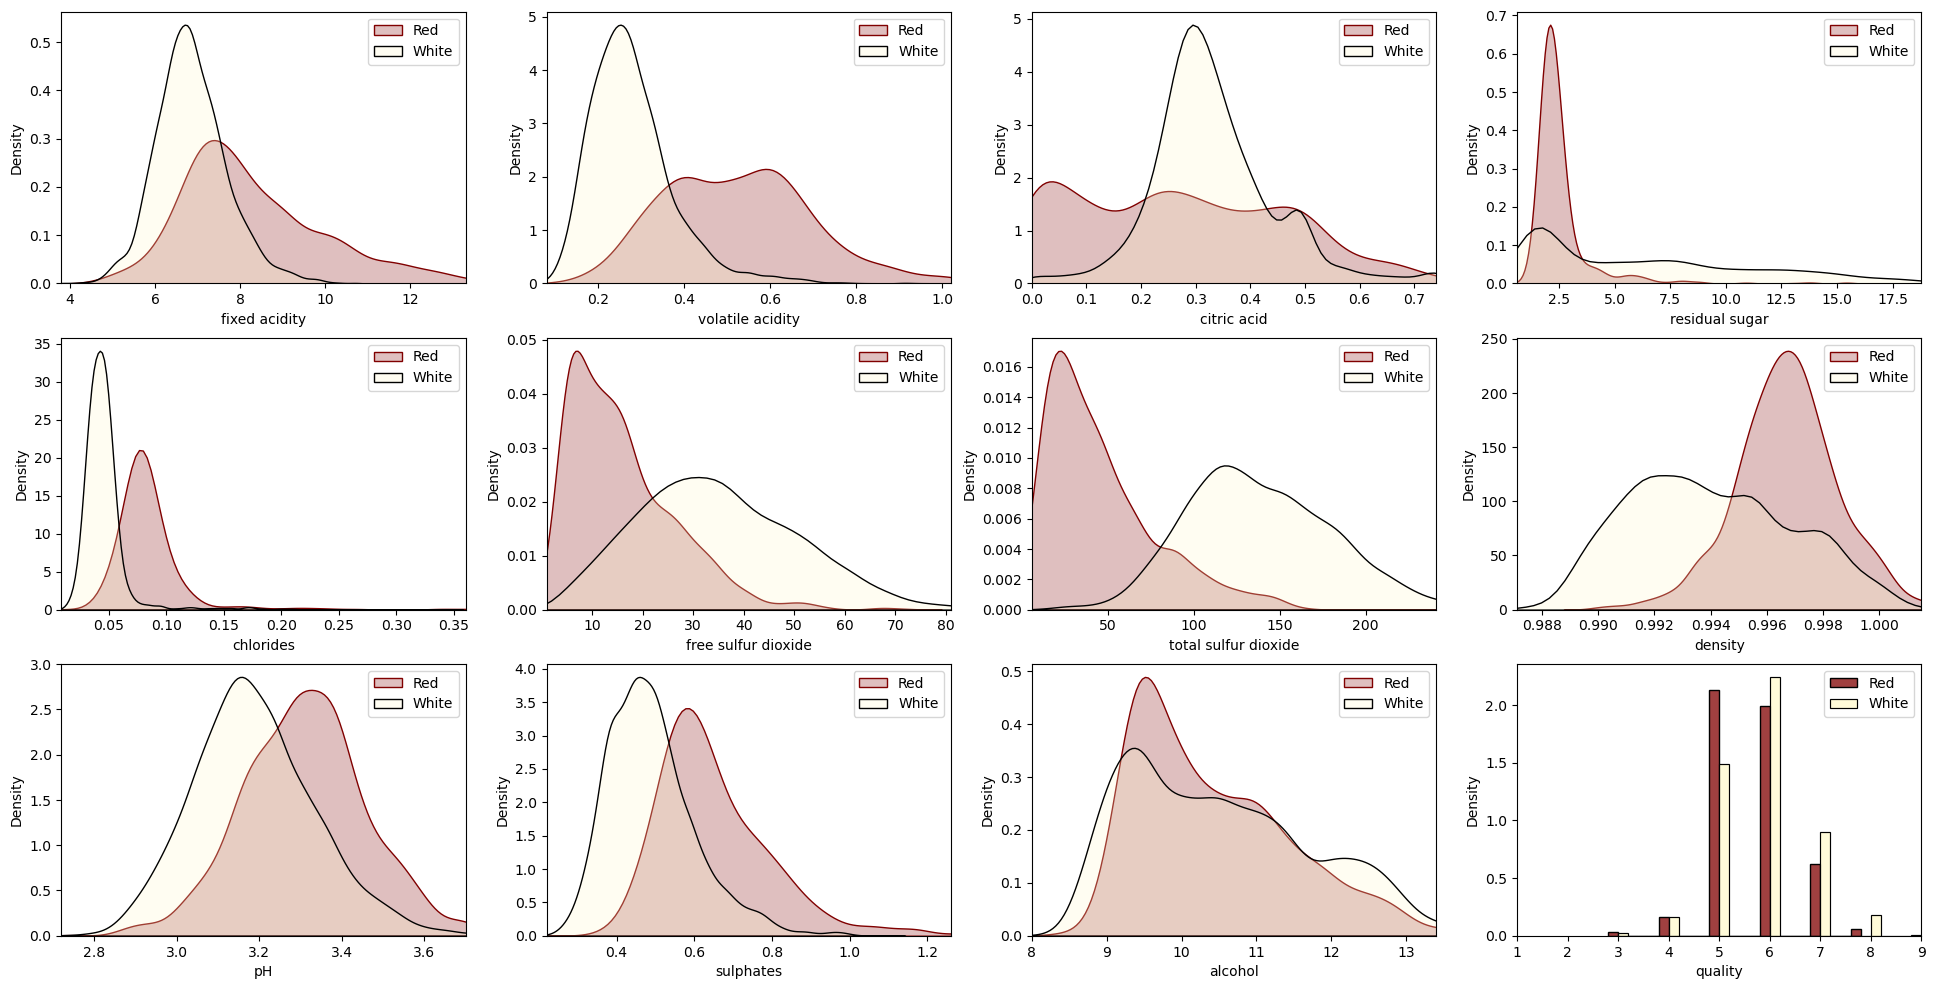

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(24, 12))
axes = axes.flatten()
for i in range(len(features_and_label)):
    f = features_and_label[i]
    ax = axes[i]
    r_ll = red[f].min()
    w_ll = white[f].min()
    r_ul = red[f].quantile(0.99)
    w_ul = white[f].quantile(0.99)
    if r_ul > w_ul:
        ul = r_ul
    else:
        ul = w_ul
    if r_ll > w_ll:
        ll = w_ll
    else:
        ll = r_ll
    if i != len(features_and_label)-1:
        sns.kdeplot(red[f], color = colors[0], fill = True, label = "Red", ax=ax)
        sns.kdeplot(white[f], color = colors[1], edgecolor = "black", fill = True, label = "White", ax=ax)
        ax.legend()
        ax.set_xlim(ll, ul)
    else:
        sns.histplot(red[f]-0.2, binwidth = 0.2, stat = "density", color = colors[0], fill = True, label = "Red", ax=ax)
        sns.histplot(white[f], binwidth = 0.2, stat = "density", color = colors[1], edgecolor = "black", fill = True, label = "White", ax=ax)
        ax.legend()
        ax.set_xlim(1, 9)


plt.show()

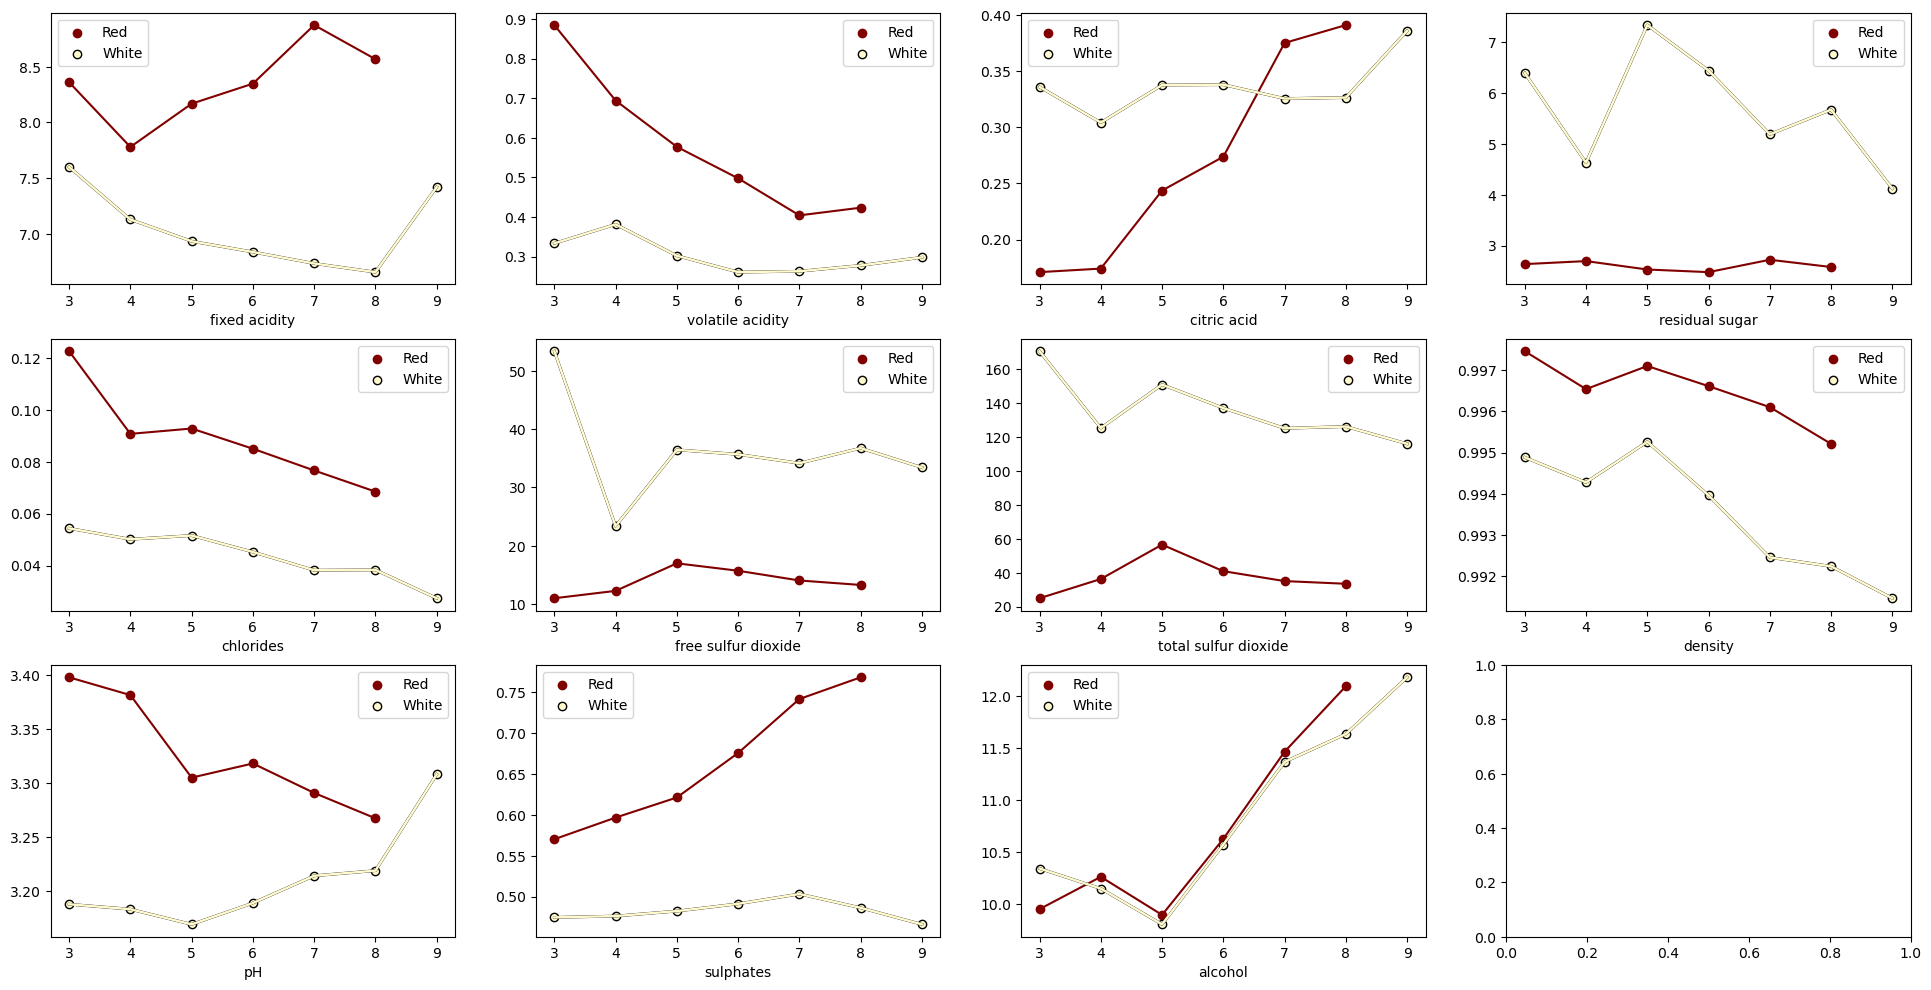

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(24, 12))
axes = axes.flatten()
red_2 = red.drop("color", axis = 1).groupby("quality").mean()
white_2 = white.drop("color", axis = 1).groupby("quality").mean()
for i in range(len(features_and_label)):
    f = features_and_label[i]
    ax = axes[i]
    if i != len(features_and_label)-1:
        ax.scatter(red_2.index, red_2[f], color = colors[0], label = "Red")
        ax.plot(red_2.index, red_2[f], color = colors[0], linestyle='-')
        ax.scatter(white_2.index, white_2[f], color = colors[1], edgecolor = "black", label = "White")
        ax.plot(white_2.index, white_2[f], color = "black", linewidth=2, linestyle='-')
        ax.plot(white_2.index, white_2[f], color = colors[1], linewidth=1.8, linestyle='-')
        ax.set_xlabel(f)
        ax.legend()
        

plt.show()

**Base Linear Regression**

In [11]:
wine = {}
wine["red"] = {}
wine["white"] = {}
wine["red"]["X"] = red[features]
wine["white"]["X"] = white[features]
wine["red"]["y"] = red["quality"]
wine["white"]["y"] = white["quality"]
for c in wine:
    X_train, X_test, y_train, y_test = train_test_split(wine[c]["X"], wine[c]["y"], test_size = 0.2, random_state=0)
    wine[c]["X_train"] = X_train
    wine[c]["X_test"] = X_test
    wine[c]["y_train"] = y_train
    wine[c]["y_test"] = y_test

red


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


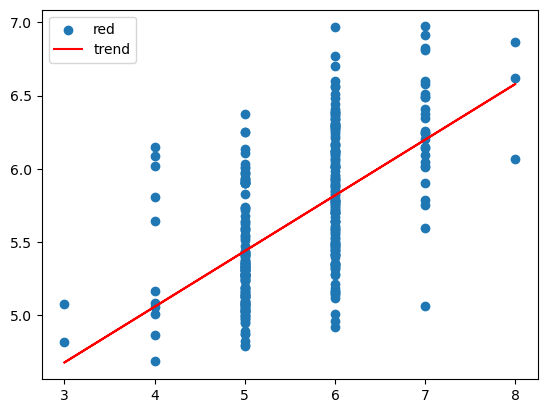

white


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


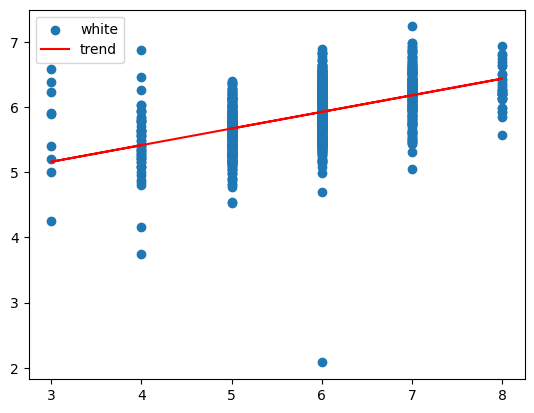

,color,rmse,r2,int,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,red,0.620057,0.328389,34.998711,0.0413,-1.1495,-0.1779,0.0279,-1.8734,0.0027,-0.0028,-31.5167,-0.2545,0.924,0.2678
1,white,0.812309,0.251348,188.459295,0.1070,-1.8103,-0.0152,0.0929,-0.5567,0.0044,-0.0003,-188.9926,0.8224,0.639,0.1378


In [12]:
lr_results = pd.DataFrame(columns = ["color", "rmse", "r2", "int"] + features)
for c in wine:
    print(c)
    X_train = wine[c]["X_train"]
    X_test = wine[c]["X_test"]
    y_train = wine[c]["y_train"]
    y_test = wine[c]["y_test"] 
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    coef = [round(coef, 4) for coef in model.coef_]
    int = model.intercept_
    y_pred = model.predict(X_test)
    wine[c]["y_pred_lr"] = y_pred
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    lr_results.loc[len(lr_results)] = [c, rmse, r2, int] + coef
    plt.figure()
    plt.scatter(y_test, y_pred, label = c)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color = "red", label = "trend")
    plt.legend()
    plt.show()
    plt.close()
    

lr_results

**Standardization: StandardScaler**

red


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


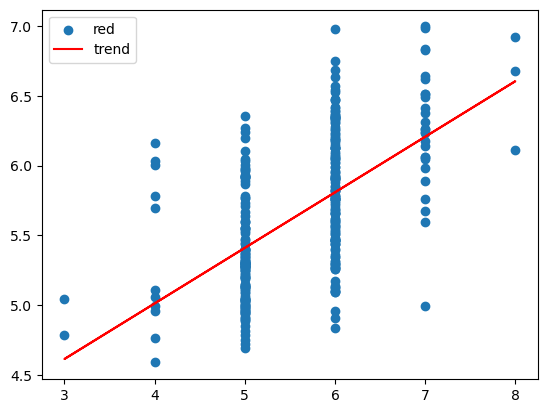

white


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


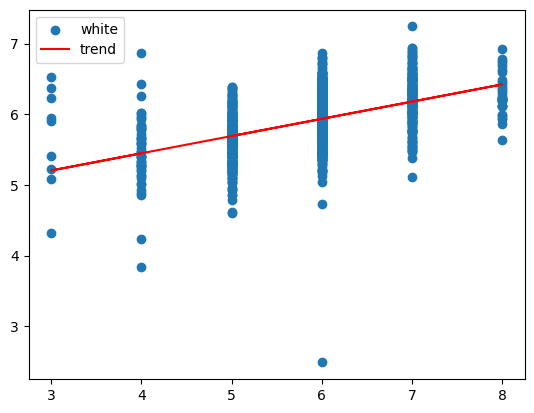

,color,rmse,r2,int,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,red,0.621603,0.325037,5.646599,0.0716,-0.2098,-0.0348,0.0405,-0.0895,0.0282,-0.0932,-0.0593,-0.0392,0.1615,0.2841
1,white,0.812692,0.250642,5.892037,0.0883,-0.1816,-0.0018,0.4640,-0.0123,0.0749,-0.0121,-0.5540,0.1240,0.0739,0.1700


In [14]:
st_results = pd.DataFrame(columns = ["color", "rmse", "r2", "int"] + features)
for c in wine:
    print(c)
    X_train = wine[c]["X_train"]
    X_test = wine[c]["X_test"]
    y_train = wine[c]["y_train"]
    y_test = wine[c]["y_test"] 
    model = linear_model.LinearRegression()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    model.fit(X_train, y_train)
    coef = [round(coef, 4) for coef in model.coef_]
    int = model.intercept_
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    st_results.loc[len(st_results)] = [c, rmse, r2, int] + coef
    plt.figure()
    plt.scatter(y_test, y_pred, label = c)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color = "red", label = "trend")
    plt.legend()
    plt.show()
    plt.close()

st_results

**Lasso**

C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


red


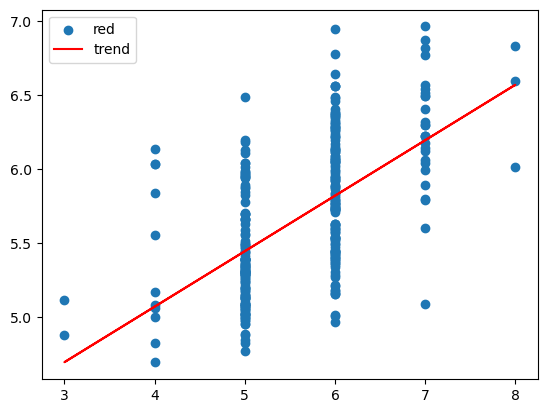

white


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


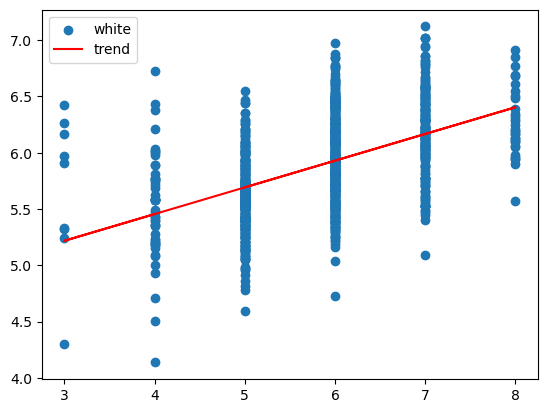

,color,rmse,r2,int,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,red,0.619194,0.330259,3.604671,0.0163,-1.1548,-0.1158,0.0121,-1.3078,0.0030,-0.0028,-0.0,-0.2776,0.7813,0.2996
1,white,0.814208,0.247843,1.953998,-0.0410,-1.7840,-0.0000,0.0254,-0.0000,0.0057,-0.0012,-0.0,0.1722,0.3106,0.3626


In [16]:
lasso_results = pd.DataFrame(columns = ["color", "rmse", "r2", "int"] + features)
for c in wine:
    print(c)
    X_train = wine[c]["X_train"]
    X_test = wine[c]["X_test"]
    y_train = wine[c]["y_train"]
    y_test = wine[c]["y_test"] 
    model = linear_model.Lasso(alpha = 0.001)
    model.fit(X_train, y_train)
    coef = [round(coef, 4) for coef in model.coef_]
    int = model.intercept_
    y_pred = model.predict(X_test)
    wine[c]["y_pred_lasso"] = y_pred
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    lasso_results.loc[len(lasso_results)] = [c, rmse, r2, int] + coef
    plt.figure()
    plt.scatter(y_test, y_pred, label = c)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color = "red", label = "trend")
    plt.legend()
    plt.show()
    plt.close()

lasso_results

**Random Forest**

In [18]:
#params={"n_estimators": [25, 50, 100, 125, 150, 175, 200], "criterion": ['squared_error'], "max_depth": [1, 5, 9, 13, 17, 20]}
#model = RandomForestRegressor(random_state=0)
# for c in wine:
# print(c)
#   X_train = wine[c]["X_train"]
#    X_test = wine[c]["X_test"]
#    y_train = wine[c]["y_train"]
#    y_test = wine[c]["y_test"] 
#    grid = GridSearchCV(model, params)
#    grid.fit(X_train, y_train)
#    wine[c]["rf_param"] = grid.best_params_

In [19]:
wine["white"]["rf_param"] = {'criterion': 'squared_error', 'max_depth': 20, 'n_estimators': 200}
wine["red"]["rf_param"] = {'criterion': 'squared_error', 'max_depth': 20, 'n_estimators': 175}

red


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


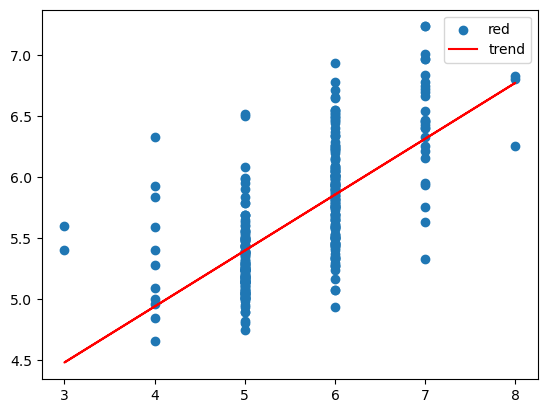

white


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


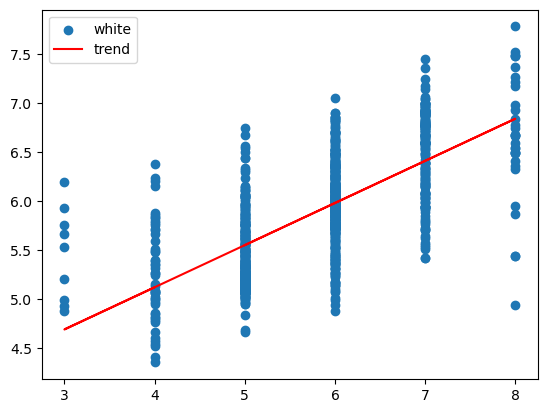

,color,rmse,r2
0,red,0.568757,0.434923
1,white,0.688388,0.462344


In [20]:
tree_results = pd.DataFrame(columns = ["color", "rmse", "r2"])
for c in wine:
    print(c)
    X_train = wine[c]["X_train"]
    X_test = wine[c]["X_test"]
    y_train = wine[c]["y_train"]
    y_test = wine[c]["y_test"] 
    model = RandomForestRegressor(n_estimators = wine[c]["rf_param"]["n_estimators"], criterion="squared_error", max_depth=wine[c]["rf_param"]["max_depth"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    wine[c]["y_pred_rf"] = y_pred
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    tree_results.loc[len(tree_results)] = [c, rmse, r2]
    plt.figure()
    plt.scatter(y_test, y_pred, label = c)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color = "red", label = "trend")
    plt.legend()
    plt.show()
    plt.close()


tree_results

**kNN**

In [22]:
params={"n_neighbors": [3, 4, 5, 6, 7], "metric": ['euclidean', 'manhattan']}
model = KNeighborsRegressor()
for c in wine:
    print(c)
    X_train = wine[c]["X_train"]
    X_test = wine[c]["X_test"]
    y_train = wine[c]["y_train"]
    y_test = wine[c]["y_test"] 
    grid = GridSearchCV(model, params)
    grid.fit(X_train, y_train)
    wine[c]["kn_param"] = grid.best_params_

red
white


red


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


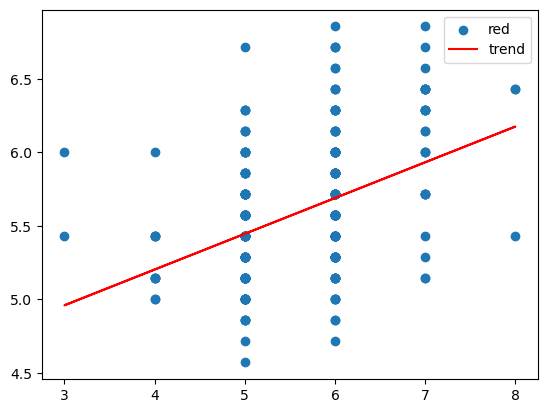

white


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


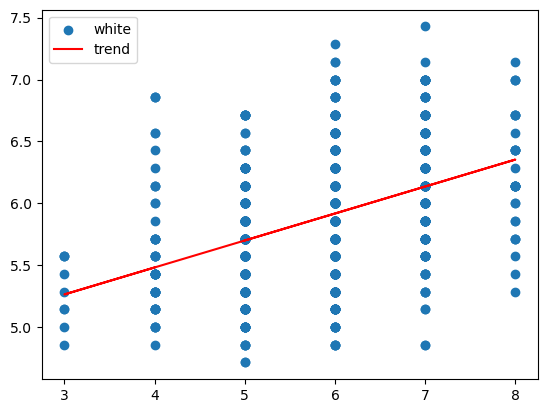

,color,rmse,r2
0,red,0.697847,0.149305
1,white,0.867347,0.146460


In [23]:
kNN_results = pd.DataFrame(columns = ["color", "rmse", "r2"])
for c in wine:
    print(c)
    X_train = wine[c]["X_train"]
    X_test = wine[c]["X_test"]
    y_train = wine[c]["y_train"]
    y_test = wine[c]["y_test"] 
    model = KNeighborsRegressor(n_neighbors = wine[c]["kn_param"]["n_neighbors"], metric = wine[c]["kn_param"]["metric"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    wine[c]["y_pred_kNN"] = y_pred
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    kNN_results.loc[len(kNN_results)] = [c, rmse, r2]
    plt.figure()
    plt.scatter(y_test, y_pred, label = c)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color = "red", label = "trend")
    plt.legend()
    plt.show()
    plt.close()


kNN_results

**PCA**

In [25]:
from sklearn.decomposition import PCA

red


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


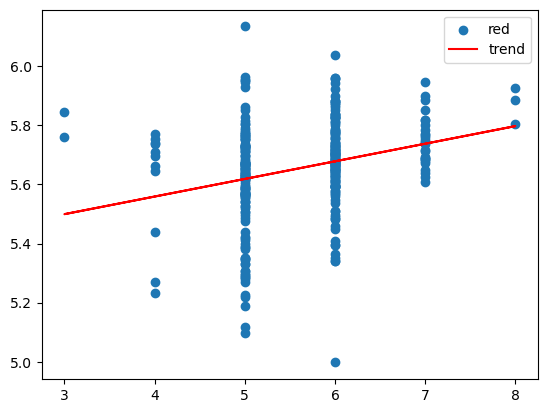

white


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


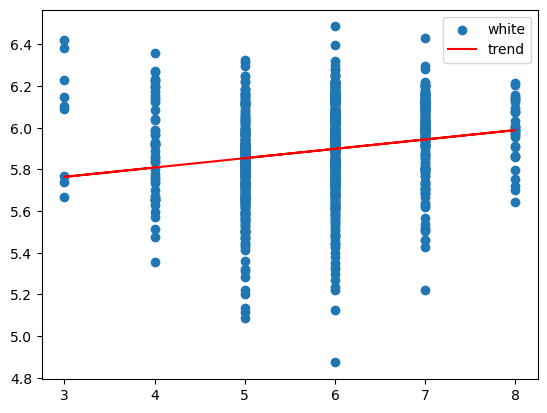

,color,rmse,r2
0,red,0.731741,0.064661
1,white,0.925237,0.028722


In [26]:
pca_results = pd.DataFrame(columns = ["color", "rmse", "r2"])
for c in wine:
    print(c)
    X_train = wine[c]["X_train"]
    X_test = wine[c]["X_test"]
    y_train = wine[c]["y_train"]
    y_test = wine[c]["y_test"] 
    pca = PCA(n_components=3, random_state = 0)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    coef = [round(coef, 5) for coef in model.coef_]
    int = model.intercept_
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    pca_results.loc[len(pca_results)] = [c, rmse, r2]
    plt.figure()
    plt.scatter(y_test, y_pred, label = c)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color = "red", label = "trend")
    plt.legend()
    plt.show()
    plt.close()
    


pca_results

In [27]:
for c in wine:
    wine[c]["y_pred_mean"] = (wine[c]["y_pred_lr"]+wine[c]["y_pred_lasso"]+wine[c]["y_pred_rf"]+wine[c]["y_pred_kNN"])/4

C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


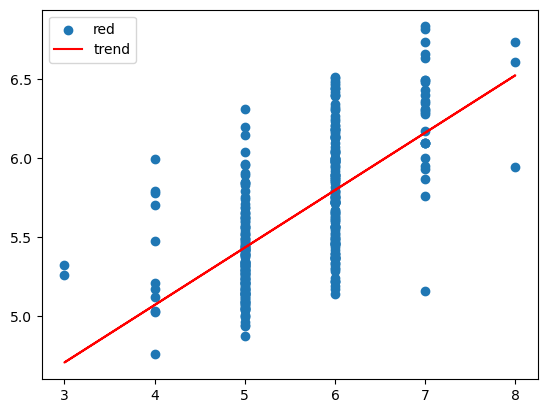

C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


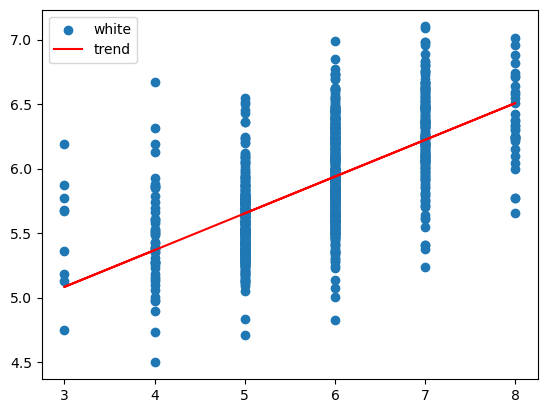

,color,rmse,r2
0,red,0.589005,0.393973
1,white,0.756587,0.350535


In [28]:
combined_results = pd.DataFrame(columns = ["color", "rmse", "r2"])
for c in wine:
    X_train = wine[c]["X_train"]
    X_test = wine[c]["X_test"]
    y_train = wine[c]["y_train"]
    y_test = wine[c]["y_test"] 
    y_pred = wine[c]["y_pred_mean"]
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    combined_results.loc[len(combined_results)] = [c, rmse, r2]
    plt.figure()
    plt.scatter(y_test, y_pred, label = c)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color = "red", label = "trend")
    plt.legend()
    plt.show()
    plt.close()
    


combined_results

In [29]:
a, b = wines["quality"].min(), wines["quality"].max()
for c in wine:
    x_min, x_max = wine[c]["y_pred_mean"].min(), wine[c]["y_pred_mean"].max()
    wine[c]["y_pred_scaled"] = a + ((wine[c]["y_pred_mean"]-x_min) * (b-a))/(x_max-x_min)

wine["red"]["y_pred_scaled"]

array([5.49137801, 3.31553888, 8.4183379 , 4.66699257, 5.83319001,
       4.55188929, 4.96432594, 6.6931218 , 3.7539253 , 4.10508351,
       4.65577756, 5.04427658, 5.44944984, 4.81024681, 5.08987864,
       7.09488365, 8.94464839, 5.97816991, 6.09801186, 4.17502076,
       7.4923284 , 5.00403452, 5.86337143, 5.97954891, 5.20879867,
       3.83149712, 4.44105491, 7.83443422, 4.15857122, 7.48920929,
       6.45386403, 5.92036219, 5.60274604, 4.66774756, 6.86186007,
       7.42610293, 4.38800779, 5.44551059, 7.30990281, 5.89864739,
       5.22953085, 6.86488561, 7.99637605, 7.92204366, 6.13389311,
       3.79898385, 4.32187469, 6.27129378, 5.00985965, 6.28392338,
       5.17366611, 4.53446866, 5.75433442, 7.79849755, 5.59143427,
       4.37840239, 3.96031152, 4.62396328, 7.87485471, 4.83334479,
       4.20641409, 5.88357474, 6.40699352, 6.7851169 , 4.30053095,
       6.56698502, 4.62506816, 6.12191358, 7.87055164, 7.16783307,
       4.75591201, 4.82241053, 3.78846562, 4.9565508 , 5.68855

C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


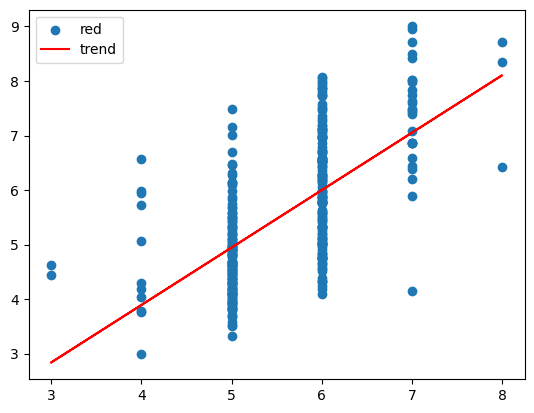

C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


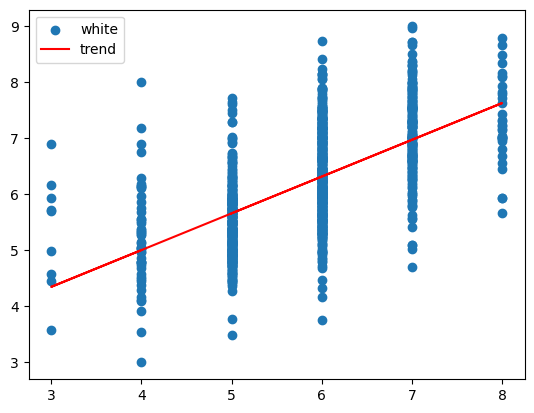

,color,rmse,r2
0,red,0.971475,-0.648608
1,white,0.934199,0.009813


In [30]:
scaled_results = pd.DataFrame(columns = ["color", "rmse", "r2"])
for c in wine:
    X_train = wine[c]["X_train"]
    X_test = wine[c]["X_test"]
    y_train = wine[c]["y_train"]
    y_test = wine[c]["y_test"] 
    y_pred = wine[c]["y_pred_scaled"]
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    scaled_results.loc[len(scaled_results)] = [c, rmse, r2]
    plt.figure()
    plt.scatter(y_test, y_pred, label = c)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color = "red", label = "trend")
    plt.legend()
    plt.show()
    plt.close()
    


scaled_results

**Best Model: Random Forest Regression**

In [32]:
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,Red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,Red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,Red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,White
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,White
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,White
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,White


red


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


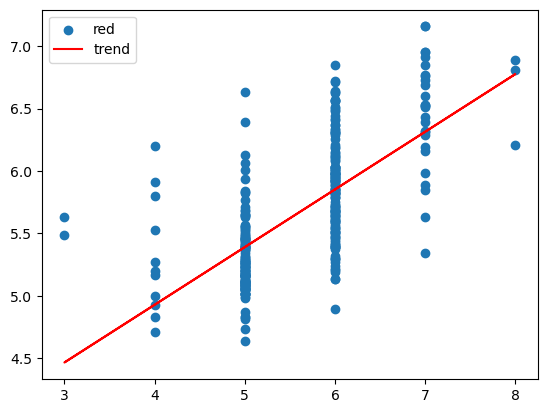

white


C:\Users\magca\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


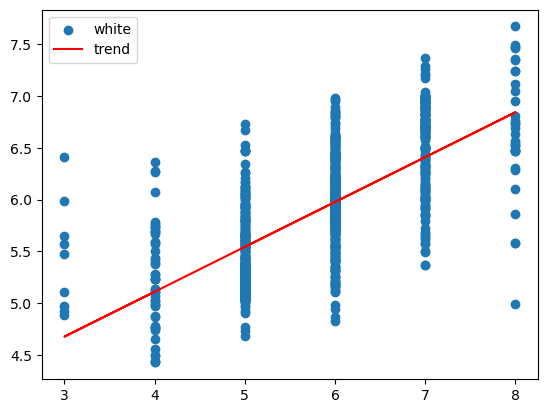

,color,rmse,r2
0,red,0.566099,0.440191
1,white,0.685457,0.466912


In [33]:
tree_results = pd.DataFrame(columns = ["color", "rmse", "r2"])
for c in wine:
    print(c)
    X_train = wine[c]["X_train"]
    X_test = wine[c]["X_test"]
    y_train = wine[c]["y_train"]
    y_test = wine[c]["y_test"] 
    model = RandomForestRegressor(n_estimators = wine[c]["rf_param"]["n_estimators"], criterion="squared_error", max_depth=wine[c]["rf_param"]["max_depth"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    wine[c]["y_pred_rf"] = y_pred
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    tree_results.loc[len(tree_results)] = [c, rmse, r2]
    plt.figure()
    plt.scatter(y_test, y_pred, label = c)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), color = "red", label = "trend")
    plt.legend()
    plt.show()
    plt.close()


tree_results

In [34]:
red_test = red[red.index.isin(wine["red"]["y_test"].index)]
red_test

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,Red
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,Red
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5,Red
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,7.5,0.310,0.41,2.4,0.065,34.0,60.0,0.99492,3.34,0.85,11.4,6,Red
1588,7.2,0.660,0.33,2.5,0.068,34.0,102.0,0.99414,3.27,0.78,12.8,6,Red
1589,6.6,0.725,0.20,7.8,0.073,29.0,79.0,0.99770,3.29,0.54,9.2,5,Red
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,Red


In [35]:
df = pd.DataFrame({"y_test": wine["red"]["y_test"],"y_pred": wine["red"]["y_pred_rf"]})
red = pd.merge(red, df, left_index=True, right_index=True, how="inner")
df = pd.DataFrame({"y_test": wine["white"]["y_test"],"y_pred": wine["white"]["y_pred_rf"]})
white = pd.merge(white, df, left_index=True, right_index=True, how="inner")  

In [36]:
white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,y_test,y_pred
9,8.1,0.220,0.43,1.50,0.044,28.0,129.0,0.99380,3.22,0.45,11.0,6,White,6,5.764103
12,7.9,0.180,0.37,1.20,0.040,16.0,75.0,0.99200,3.18,0.63,10.8,5,White,5,5.762533
22,6.8,0.260,0.42,1.70,0.049,41.0,122.0,0.99300,3.47,0.48,10.5,8,White,8,6.549000
29,7.2,0.320,0.36,2.00,0.033,37.0,114.0,0.99060,3.10,0.71,12.3,7,White,7,6.676530
30,8.5,0.240,0.39,10.40,0.044,20.0,142.0,0.99740,3.20,0.53,10.0,6,White,6,5.839533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4881,5.0,0.235,0.27,11.75,0.030,34.0,118.0,0.99540,3.07,0.50,9.4,6,White,6,5.956813
4888,6.8,0.220,0.36,1.20,0.052,38.0,127.0,0.99330,3.04,0.54,9.2,5,White,5,6.000767
4891,5.7,0.210,0.32,0.90,0.038,38.0,121.0,0.99074,3.24,0.46,10.6,6,White,6,5.862845
4892,6.5,0.230,0.38,1.30,0.032,29.0,112.0,0.99298,3.29,0.54,9.7,5,White,5,6.101321


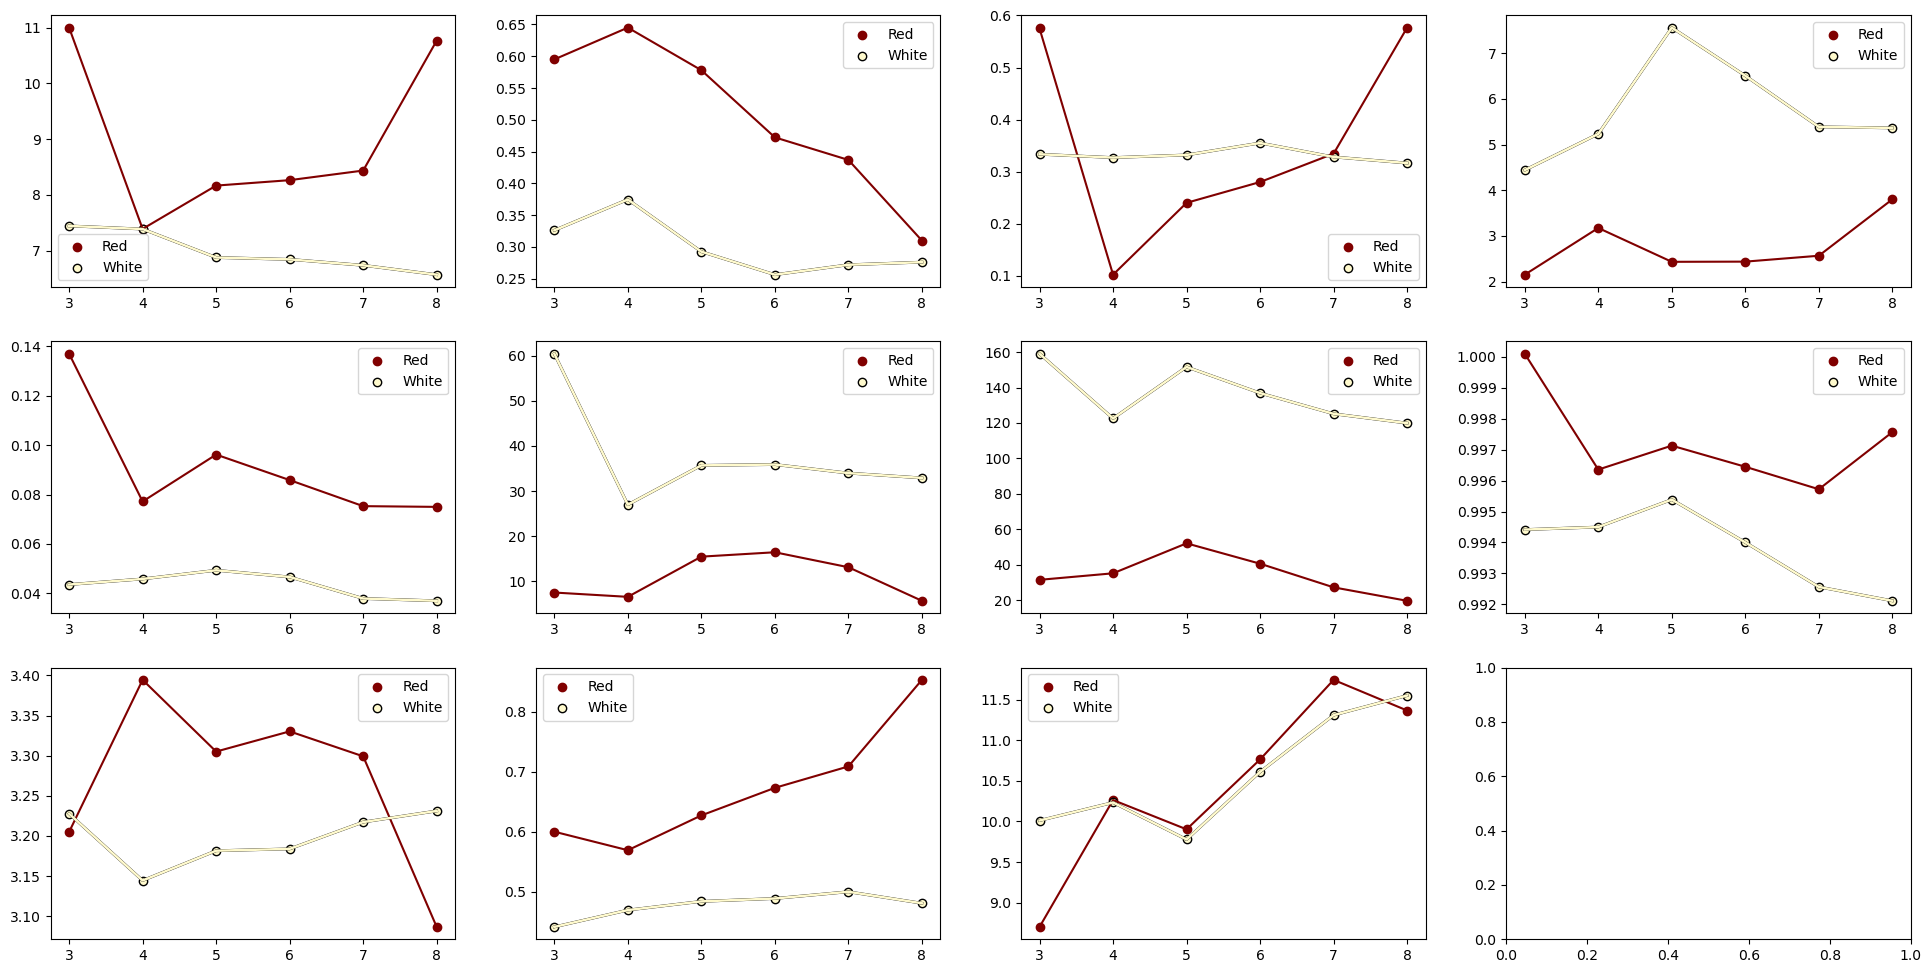

In [37]:
fig, axes = plt.subplots(3, 4, figsize=(24, 12))
axes = axes.flatten()
red_2 = red.drop("color", axis = 1).groupby("quality").mean()
white_2 = white.drop("color", axis = 1).groupby("quality").mean()
for i in range(len(features_and_label)):
    f = features_and_label[i]
    ax = axes[i]
    if i != len(features_and_label)-1:
        ax.scatter(red_2.index, red_2[f], color = colors[0], label = "Red")
        ax.plot(red_2.index, red_2[f], color = colors[0], linestyle='-')
        ax.scatter(white_2.index, white_2[f], color = colors[1], edgecolor = "black", label = "White")
        ax.plot(white_2.index, white_2[f], color = "black", linewidth=2, linestyle='-')
        ax.plot(white_2.index, white_2[f], color = colors[1], linewidth=1.8, linestyle='-')
        ax.legend()
        

plt.show()

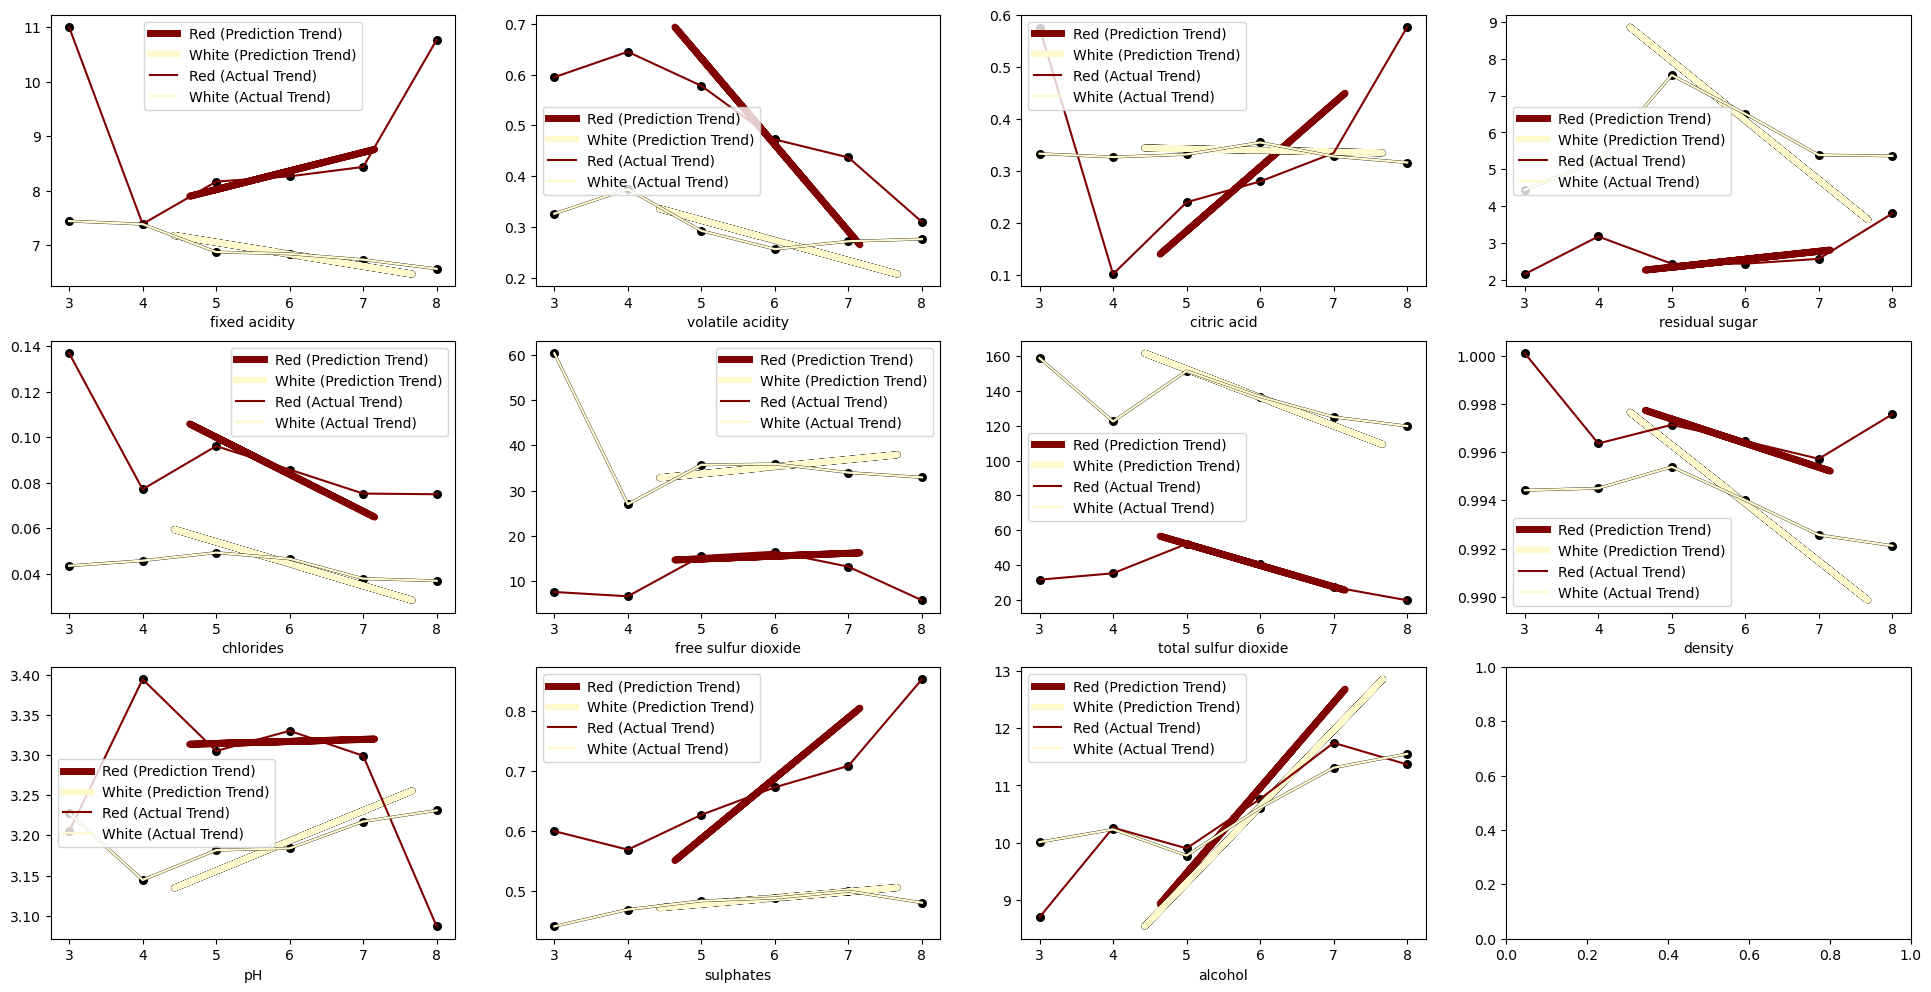

In [38]:
fig, axes = plt.subplots(3, 4, figsize=(24, 12))
axes = axes.flatten()
red_2 = red.drop("color", axis = 1).groupby("quality").mean()
white_2 = white.drop("color", axis = 1).groupby("quality").mean()
for i in range(len(features_and_label)):
    f = features_and_label[i]
    ax = axes[i]
    if i != len(features_and_label)-1:
        z = np.polyfit(red["y_pred"], red[f], 1)
        p = np.poly1d(z)
        ax.plot(red["y_pred"], p(red["y_pred"]), color = colors[0], linewidth=5, label = "Red (Prediction Trend)")
        z = np.polyfit(white["y_pred"], white[f], 1)
        p = np.poly1d(z)
        ax.plot(white["y_pred"], p(white["y_pred"]), color = "black", linewidth = 5)
        ax.plot(white["y_pred"], p(white["y_pred"]), color = colors[1], linewidth = 4.6, label = "White (Prediction Trend)")
        
        ax.plot(red_2.index, red_2[f], color = colors[0], linestyle='-', label="Red (Actual Trend)")
 
        ax.plot(white_2.index, white_2[f], color = "black", linewidth=2, linestyle='-')
        ax.plot(white_2.index, white_2[f], color = colors[1], linewidth=1.6, linestyle='-', label = "White (Actual Trend)")
        ax.scatter(red_2.index, red_2[f], color = "black", s = 30)
        ax.scatter(white_2.index, white_2[f], color = "black", s = 30, edgecolor = "black")
        ax.legend()
        ax.set_xlabel(f)
        

plt.show()

C:\Users\magca\AppData\Local\Temp\ipykernel_28772\1806633446.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(red["y_pred"], color = colors[0], shade = True, alpha = 0.8, label = "Predicted Quality (Red)")
C:\Users\magca\AppData\Local\Temp\ipykernel_28772\1806633446.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(white["y_pred"], color = colors[1], edgecolor = "black", shade = True, alpha = 0.7, label = "Predicted Quality (White)")
C:\Users\magca\AppData\Local\Temp\ipykernel_28772\1806633446.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(red["y_test"], color = "white", edgecolor = colors[0], bw_adjust = 2, sh

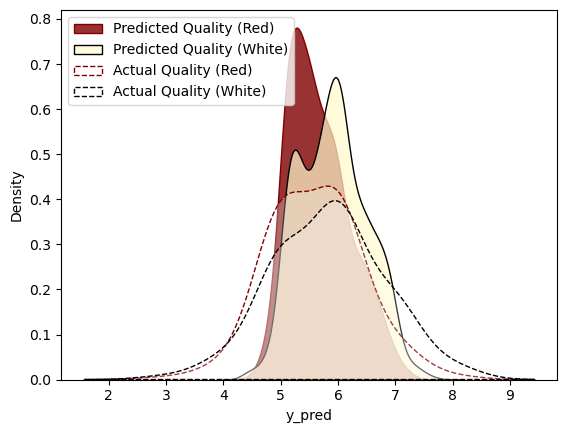

In [39]:
sns.kdeplot(red["y_pred"], color = colors[0], shade = True, alpha = 0.8, label = "Predicted Quality (Red)")
sns.kdeplot(white["y_pred"], color = colors[1], edgecolor = "black", shade = True, alpha = 0.7, label = "Predicted Quality (White)")
sns.kdeplot(red["y_test"], color = "white", edgecolor = colors[0], bw_adjust = 2, shade = True, linestyle = '--', label = "Actual Quality (Red)")
sns.kdeplot(white["y_test"], color = "white", edgecolor = "black", bw_adjust = 2, shade = True, linestyle = '--', label = "Actual Quality (White)")
plt.legend()